In [3]:
# Import required libraries
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pathlib import Path
import seaborn as sns
from collections import Counter
import random
from tqdm import tqdm

# Set style
plt.style.use('default')
sns.set_palette("husl")

# Dataset paths
dataset_dir = Path("../../Datasets/ObjectDetectionSet/bdd100k")
yolo_dir = dataset_dir / "yolo_format"
original_images_dir = dataset_dir / "bdd100k/bdd100k/images/100k"
annotations_dir = dataset_dir / "bdd100k_labels_release/bdd100k/labels"

# Class configuration
class_names = [
    'pedestrian', 'rider', 'car', 'truck', 'bus', 
    'train', 'motorcycle', 'bicycle', 'traffic light', 'traffic sign'
]

# Color palette for visualization
colors = plt.cm.Set3(np.linspace(0, 1, len(class_names)))
class_colors = {class_name: colors[i] for i, class_name in enumerate(class_names)}

print(f"📁 Dataset directory: {dataset_dir}")
print(f"📁 YOLO directory: {yolo_dir}")
print(f"📁 Original images: {original_images_dir}")
print(f"📁 Annotations: {annotations_dir}")
print(f"📋 Number of classes: {len(class_names)}")
print(f"🎨 Class colors: {list(class_colors.keys())}")


📁 Dataset directory: ../../Datasets/ObjectDetectionSet/bdd100k
📁 YOLO directory: ../../Datasets/ObjectDetectionSet/bdd100k/yolo_format
📁 Original images: ../../Datasets/ObjectDetectionSet/bdd100k/bdd100k/bdd100k/images/100k
📁 Annotations: ../../Datasets/ObjectDetectionSet/bdd100k/bdd100k_labels_release/bdd100k/labels
📋 Number of classes: 10
🎨 Class colors: ['pedestrian', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle', 'traffic light', 'traffic sign']


In [4]:
def load_yolo_annotations(label_file):
    """Load YOLO format annotations from a label file."""
    annotations = []
    
    if label_file.exists():
        with open(label_file, 'r') as f:
            lines = f.readlines()
            
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    center_x = float(parts[1])
                    center_y = float(parts[2])
                    width = float(parts[3])
                    height = float(parts[4])
                    
                    annotations.append({
                        'class_id': class_id,
                        'class_name': class_names[class_id],
                        'center_x': center_x,
                        'center_y': center_y,
                        'width': width,
                        'height': height
                    })
    
    return annotations

def yolo_to_pixel_coords(center_x, center_y, width, height, img_width, img_height):
    """Convert YOLO coordinates to pixel coordinates."""
    x_center = center_x * img_width
    y_center = center_y * img_height
    w = width * img_width
    h = height * img_height
    
    x1 = x_center - w/2
    y1 = y_center - h/2
    x2 = x_center + w/2
    y2 = y_center + h/2
    
    return x1, y1, x2, y2

def display_image_with_annotations(image_path, annotations, title="Sample Image with Annotations"):
    """Display an image with bounding box annotations."""
    # Load image
    img = Image.open(image_path)
    img_width, img_height = img.size
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(img)
    
    # Draw bounding boxes
    for ann in annotations:
        x1, y1, x2, y2 = yolo_to_pixel_coords(
            ann['center_x'], ann['center_y'], 
            ann['width'], ann['height'], 
            img_width, img_height
        )
        
        # Create rectangle
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1, 
            linewidth=2, 
            edgecolor=class_colors[ann['class_name']], 
            facecolor='none'
        )
        ax.add_patch(rect)
        
        # Add label
        ax.text(x1, y1-5, ann['class_name'], 
                color=class_colors[ann['class_name']], 
                fontsize=10, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    return len(annotations)

print("📋 Visualization functions loaded!")


📋 Visualization functions loaded!


📊 Analyzing class distribution...


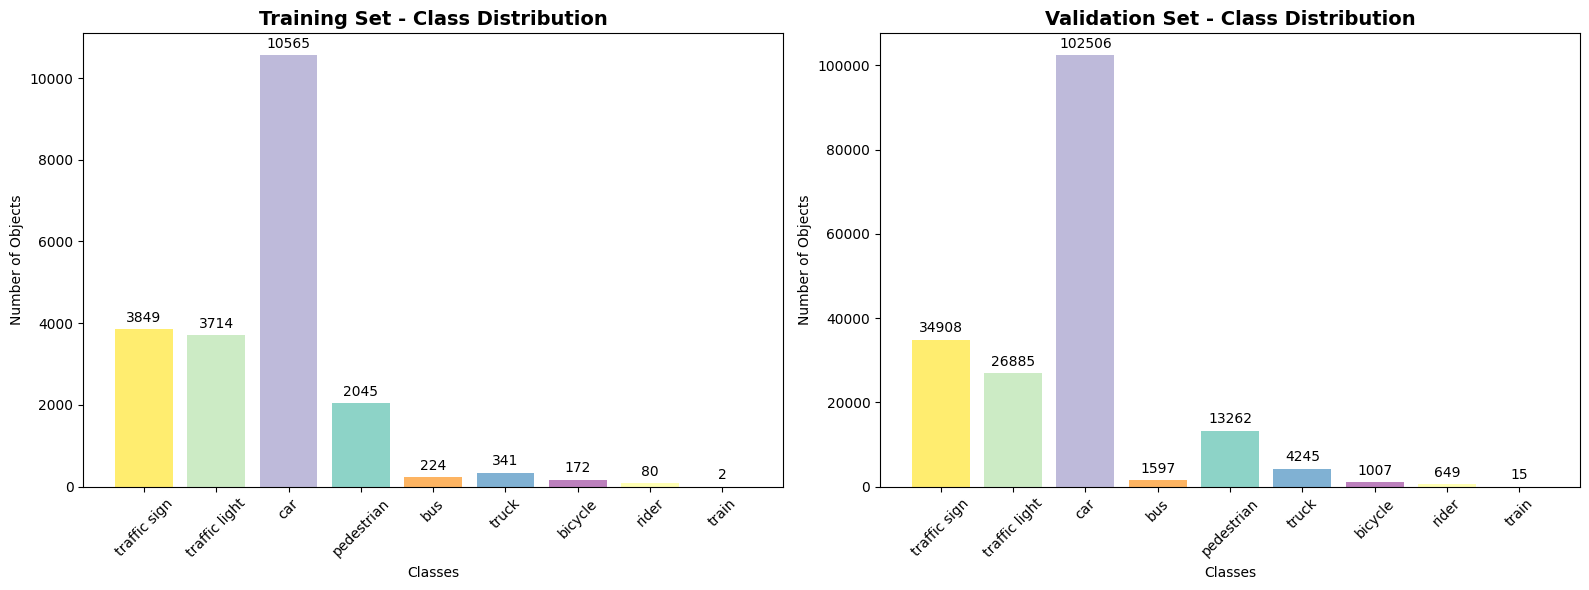


📊 Dataset Statistics:
📋 Train classes: 9
📋 Validation classes: 9
📋 Total train objects: 20992
📋 Total validation objects: 185074

📊 Most common classes in training:
  car: 10565
  traffic sign: 3849
  traffic light: 3714
  pedestrian: 2045
  truck: 341

📊 Most common classes in validation:
  car: 102506
  traffic sign: 34908
  traffic light: 26885
  pedestrian: 13262
  truck: 4245


In [5]:
# Analyze class distribution
def analyze_class_distribution():
    """Analyze and visualize class distribution in the dataset."""
    train_class_counts = Counter()
    val_class_counts = Counter()
    
    # Count classes in train split
    train_labels_dir = yolo_dir / 'labels' / 'train'
    if train_labels_dir.exists():
        for label_file in train_labels_dir.glob('*.txt'):
            annotations = load_yolo_annotations(label_file)
            for ann in annotations:
                train_class_counts[ann['class_name']] += 1
    
    # Count classes in validation split
    val_labels_dir = yolo_dir / 'labels' / 'val'
    if val_labels_dir.exists():
        for label_file in val_labels_dir.glob('*.txt'):
            annotations = load_yolo_annotations(label_file)
            for ann in annotations:
                val_class_counts[ann['class_name']] += 1
    
    return train_class_counts, val_class_counts

# Get class distribution
print("📊 Analyzing class distribution...")
train_counts, val_counts = analyze_class_distribution()

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Train distribution
if train_counts:
    classes = list(train_counts.keys())
    counts = list(train_counts.values())
    bars1 = ax1.bar(classes, counts, color=[class_colors[c] for c in classes])
    ax1.set_title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Classes')
    ax1.set_ylabel('Number of Objects')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add count labels on bars
    for bar, count in zip(bars1, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontsize=10)

# Validation distribution
if val_counts:
    classes = list(val_counts.keys())
    counts = list(val_counts.values())
    bars2 = ax2.bar(classes, counts, color=[class_colors[c] for c in classes])
    ax2.set_title('Validation Set - Class Distribution', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Classes')
    ax2.set_ylabel('Number of Objects')
    ax2.tick_params(axis='x', rotation=45)
    
    # Add count labels on bars
    for bar, count in zip(bars2, counts):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01,
                str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n📊 Dataset Statistics:")
print(f"📋 Train classes: {len(train_counts)}")
print(f"📋 Validation classes: {len(val_counts)}")
print(f"📋 Total train objects: {sum(train_counts.values())}")
print(f"📋 Total validation objects: {sum(val_counts.values())}")

print(f"\n📊 Most common classes in training:")
for class_name, count in train_counts.most_common(5):
    print(f"  {class_name}: {count}")

print(f"\n📊 Most common classes in validation:")
for class_name, count in val_counts.most_common(5):
    print(f"  {class_name}: {count}")


📸 Displaying sample training images...


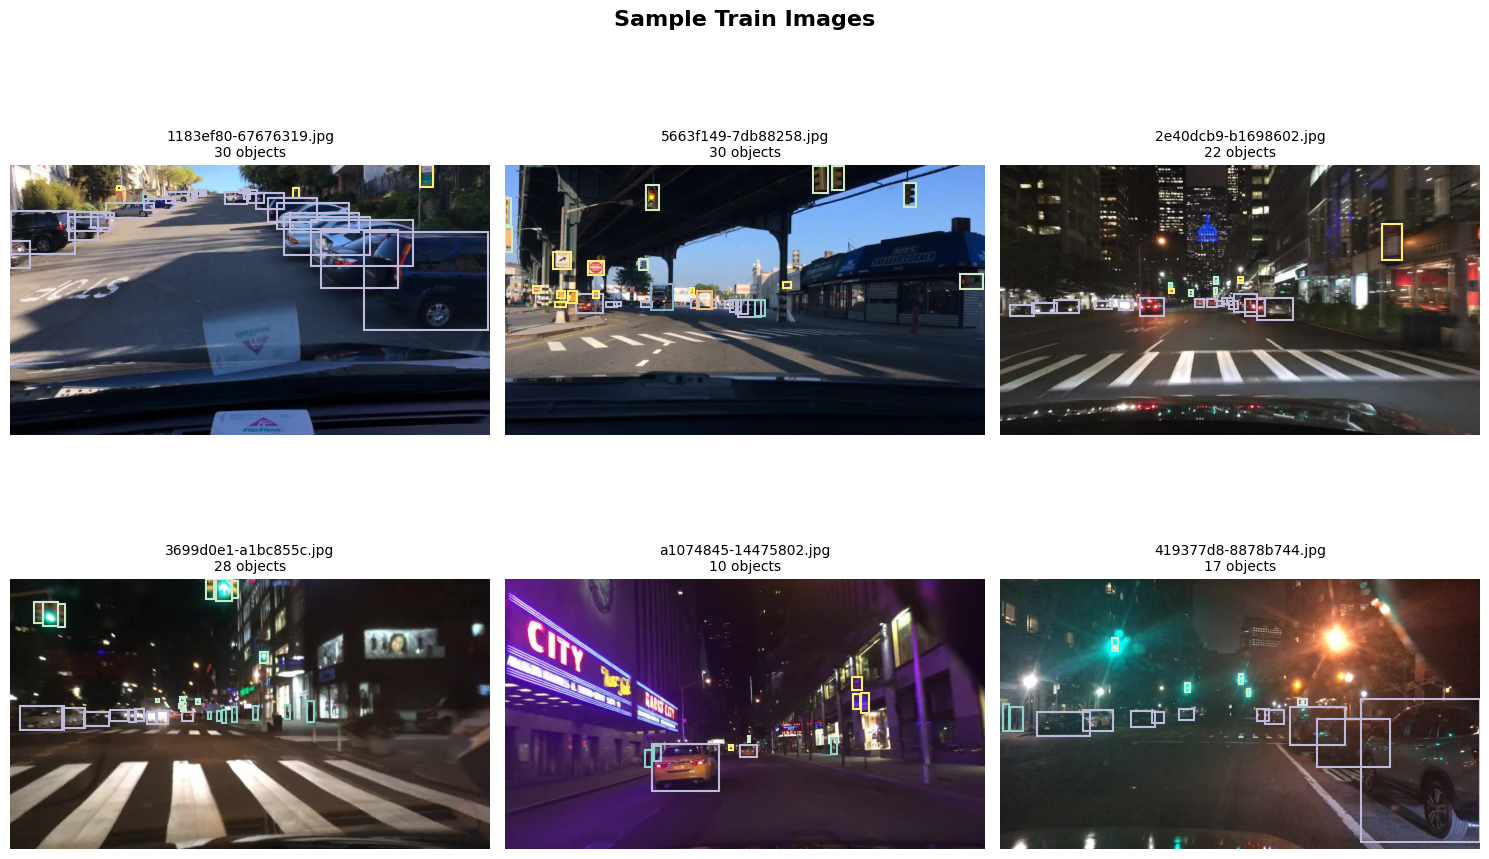


📸 Displaying sample validation images...


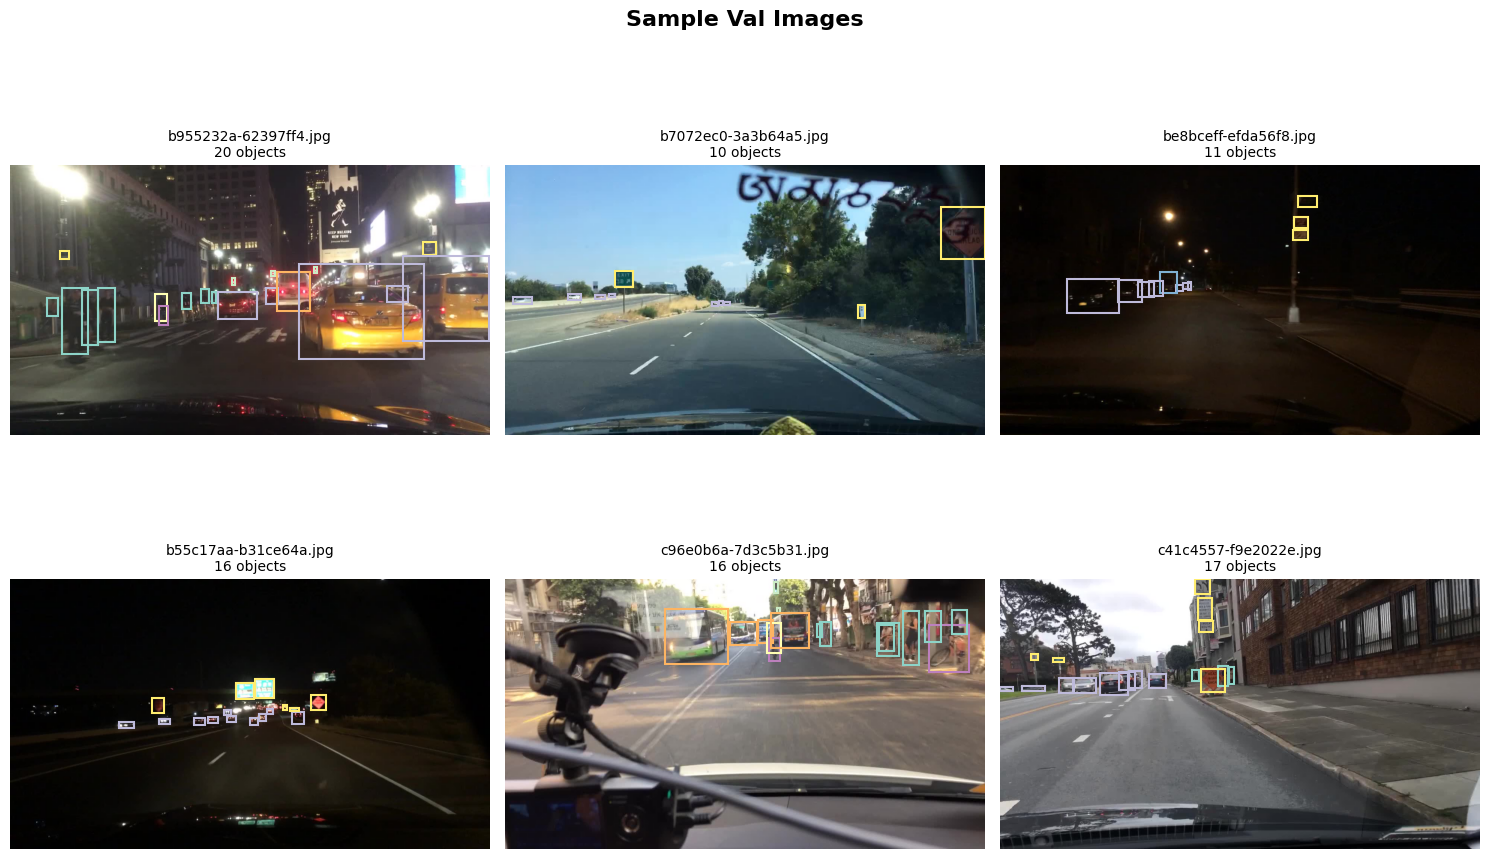

In [6]:
# Display multiple sample images in a grid
def display_sample_grid(split='train', num_samples=6):
    """Display a grid of sample images with annotations."""
    images_path = yolo_dir / 'images' / split
    labels_path = yolo_dir / 'labels' / split
    
    if not images_path.exists():
        print(f"⚠️  Images directory not found: {images_path}")
        return
    
    image_files = list(images_path.glob('*.jpg'))
    if len(image_files) < num_samples:
        num_samples = len(image_files)
    
    if num_samples == 0:
        print(f"⚠️  No images found in {images_path}")
        return
    
    # Select random samples
    sample_images = random.sample(image_files, num_samples)
    
    # Create grid
    cols = 3
    rows = (num_samples + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i, image_file in enumerate(sample_images):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        
        # Load image and annotations
        img = Image.open(image_file)
        label_file = labels_path / f"{image_file.stem}.txt"
        annotations = load_yolo_annotations(label_file)
        
        # Display image
        ax.imshow(img)
        
        # Draw bounding boxes
        img_width, img_height = img.size
        for ann in annotations:
            x1, y1, x2, y2 = yolo_to_pixel_coords(
                ann['center_x'], ann['center_y'], 
                ann['width'], ann['height'], 
                img_width, img_height
            )
            
            rect = patches.Rectangle(
                (x1, y1), x2-x1, y2-y1, 
                linewidth=1.5, 
                edgecolor=class_colors[ann['class_name']], 
                facecolor='none'
            )
            ax.add_patch(rect)
        
        # Set title with object count
        ax.set_title(f"{image_file.name}\n{len(annotations)} objects", fontsize=10)
        ax.axis('off')
    
    # Hide empty subplots
    for i in range(num_samples, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].axis('off')
    
    plt.suptitle(f"Sample {split.capitalize()} Images", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Display sample grids
print("📸 Displaying sample training images...")
display_sample_grid('train', 6)

print("\n📸 Displaying sample validation images...")
display_sample_grid('val', 6)



📸 Sample train image: af29482b-0f66b54b.jpg
📋 Number of objects: 34
📋 Objects: traffic light, traffic light, traffic light, traffic sign, traffic sign, traffic sign, traffic sign, traffic sign, traffic sign, car, car, car, car, car, car, car, car, car, car, car, traffic sign, car, car, car, car, car, car, car, car, car, car, car, car, car


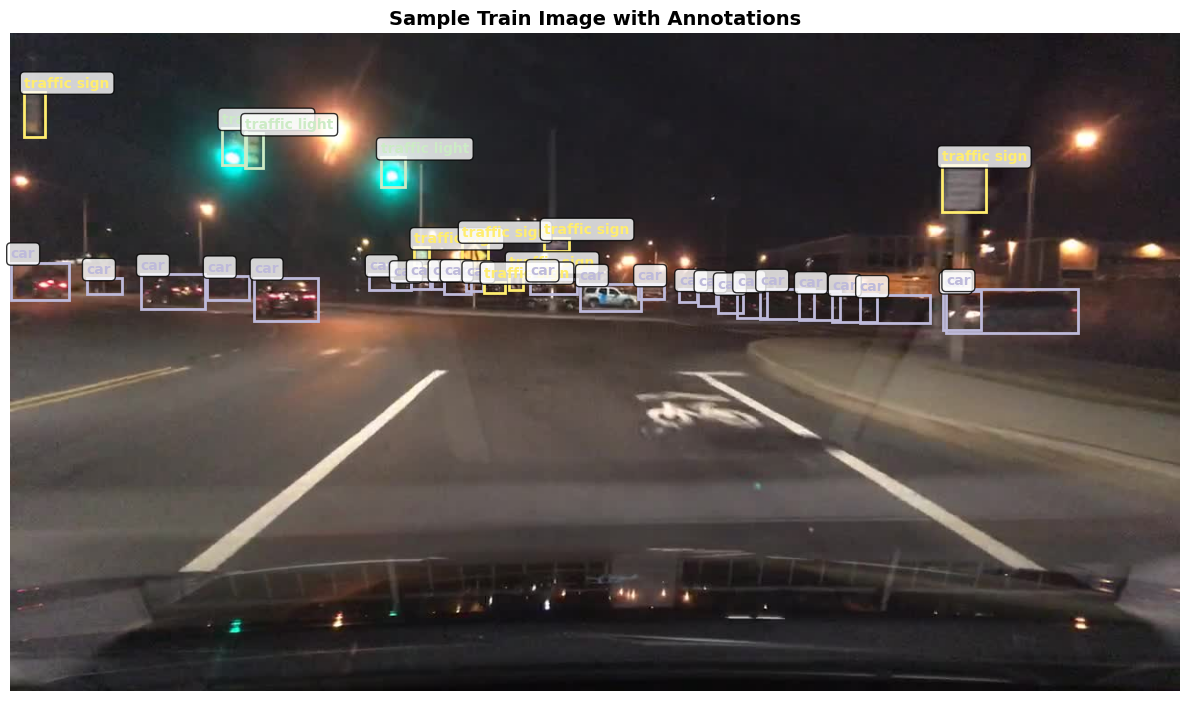


📸 Sample val image: c3321660-e6b60390.jpg
📋 Number of objects: 15
📋 Objects: traffic light, traffic light, traffic light, traffic sign, traffic sign, traffic sign, traffic sign, traffic sign, pedestrian, traffic sign, car, car, car, car, truck


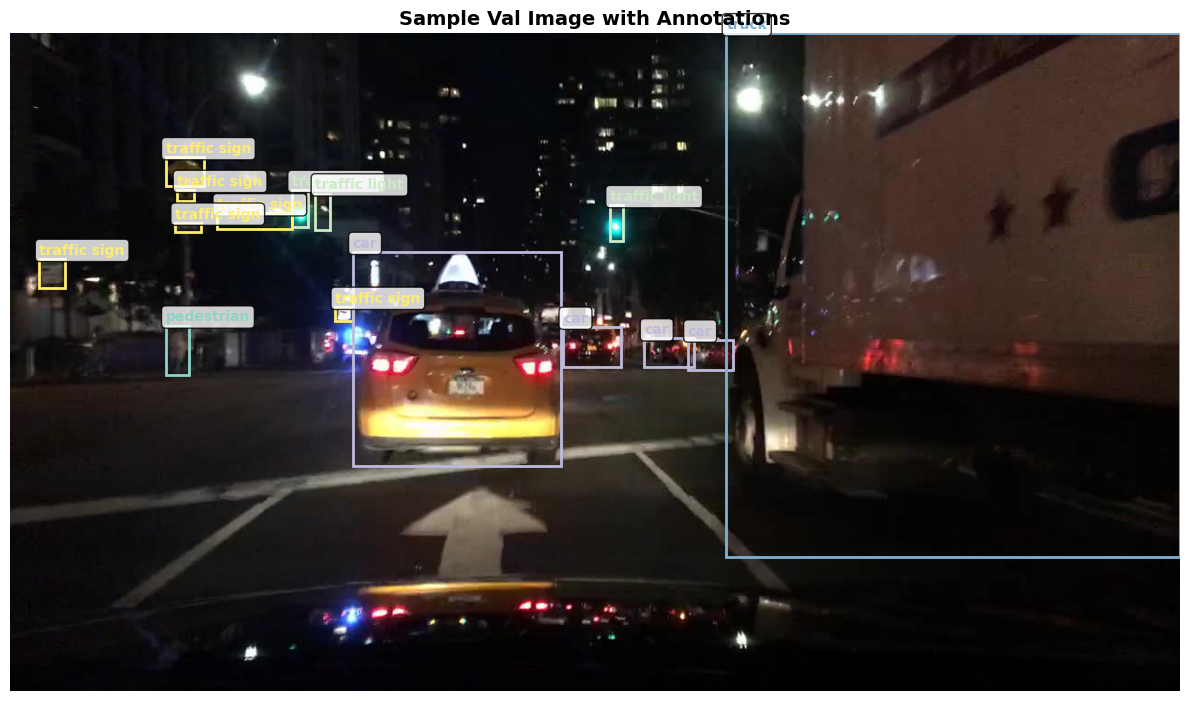

In [7]:
# Display sample images from each split
for split in ['train', 'val']:
    images_path = yolo_dir / 'images' / split
    labels_path = yolo_dir / 'labels' / split
    
    if images_path.exists():
        # Get random sample
        image_files = list(images_path.glob('*.jpg'))
        if image_files:
            sample_image = random.choice(image_files)
            sample_label = labels_path / f"{sample_image.stem}.txt"
            
            # Load annotations
            annotations = load_yolo_annotations(sample_label)
            
            if annotations:
                print(f"\n📸 Sample {split} image: {sample_image.name}")
                print(f"📋 Number of objects: {len(annotations)}")
                
                # Show object classes
                classes_in_image = [ann['class_name'] for ann in annotations]
                print(f"📋 Objects: {', '.join(classes_in_image)}")
                
                # Display image
                display_image_with_annotations(
                    sample_image, 
                    annotations, 
                    f"Sample {split.capitalize()} Image with Annotations"
                )
            else:
                print(f"⚠️ No annotations found for {sample_image.name}")
